In [1]:
# Fist install the library

#%pip install aepy

In [2]:
import os
import sys

notebook_dir = os.path.abspath('')
sys.path.append(os.path.join(notebook_dir, '..'))

import numpy as np

from sklearn.metrics import accuracy_score
from keras_core import utils

from aepy.data.datasets import load_MNIST
from aepy.data.utils import evaluate, display_diff, add_noise
from aepy.models.ae.ae_model import AE
from aepy.models.base.default_architectures import VanillaEncoder, VanillaDecoder
from aepy.pipelines.training import TrainingPipeline

Using TensorFlow backend


2023-12-07 00:35:47.075208: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-07 00:35:47.075240: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-07 00:35:47.076169: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-07 00:35:47.081578: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-07 00:35:47.694714: W tensorflow/compiler/tf2

Download and preprocess the dataset. In this example, the selected dataset is the well-known MNIST composed of handwritten number images.

In [3]:
# Load MNIST dataset
x_train, y_train, x_test, y_test = load_MNIST(persistant=True)

# Obtaint number of clasess
n_classes = len(set(y_train))

# Convert labels to categorical
y_train = utils.to_categorical(y_train, n_classes)
y_test = utils.to_categorical(y_test, n_classes)

2023-12-07 00:35:48 [INFO]: train-images-idx3-ubyte.gz already exists.
2023-12-07 00:35:48 [INFO]: train-labels-idx1-ubyte.gz already exists.
2023-12-07 00:35:48 [INFO]: t10k-images-idx3-ubyte.gz already exists.
2023-12-07 00:35:48 [INFO]: t10k-labels-idx1-ubyte.gz already exists.


Since we want to train a denoising autoencoder, we also need to add some noise to the images.
The noise factor should be a float between 0 and 1.

In [4]:
# Add noise to the train and test data
x_train_noisy = add_noise(x_train, noise_factor=0.4)
x_test_noisy = add_noise(x_test, noise_factor=0.4)

x_train = x_train.reshape(x_train.shape[0], -1)
x_train_noisy = x_train_noisy.reshape(x_train_noisy.shape[0], -1)
x_test = x_test.reshape(x_test.shape[0], -1)
x_test_noisy = x_test_noisy.reshape(x_test_noisy.shape[0], -1)

Compose the dictionaries to feed the autoencoder during training and evaluation phase.
Note in train how the train labels correspond to the original MNIST images (without noise).

In [5]:
train_data = dict(data=x_train_noisy.astype(float), labels=x_train)
test_data = dict(data=x_test_noisy.astype(float), labels=y_test)

Since the denoising autoencoder in structure is a normal autoencoder (only its functionality varies), the encoder and decoder are the vanilla ones, you can specify the depth and number of neurons per layer in each using the layers_conf parameter.

In [8]:
# Model creation
model = AE(input_dim=x_train_noisy.shape[1], latent_dim=2,
           encoder=VanillaEncoder, decoder=VanillaDecoder, layers_conf=[64, 32])

Define the training pipeline. There you can fix some hyperparameters realted to the training phase of the autoencoder, like learning rate, bath size, numer of epochs, etc

In [9]:
pipe = TrainingPipeline(name='training_pipeline',
                        model=model, num_epochs=10)

trained_model = pipe(train_data=train_data)

2023-12-07 00:36:53 [INFO]: +++ training_pipeline +++
2023-12-07 00:36:53 [INFO]: Creating folder in ../output_dir/training_pipeline_2023-12-07_00-36-53


Epoch 1/10
{'recon_loss': <tf.Tensor 'Mean_1:0' shape=() dtype=float32>}
{'recon_loss': <tf.Tensor 'Mean_1:0' shape=() dtype=float32>}
{'recon_loss': <tf.Tensor 'Mean_1:0' shape=() dtype=float32>}

Epoch 1: total_loss improved from inf to 0.11675, saving model to ../output_dir/training_pipeline_2023-12-07_00-36-53/model.weights.h5
469/469 - 8s - 18ms/step - reconstruction_loss: 0.1167 - total_loss: 0.1167
Epoch 2/10

Epoch 2: total_loss improved from 0.11675 to 0.11295, saving model to ../output_dir/training_pipeline_2023-12-07_00-36-53/model.weights.h5
469/469 - 2s - 4ms/step - reconstruction_loss: 0.1130 - total_loss: 0.1130
Epoch 3/10

Epoch 3: total_loss improved from 0.11295 to 0.10669, saving model to ../output_dir/training_pipeline_2023-12-07_00-36-53/model.weights.h5
469/469 - 2s - 4ms/step - reconstruction_loss: 0.1067 - total_loss: 0.1067
Epoch 4/10

Epoch 4: total_loss improved from 0.10669 to 0.10382, saving model to ../output_dir/training_pipeline_2023-12-07_00-36-53/model

Evaluation phase using test data

In [10]:
y_hat = trained_model.predict(test_data)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


Finally the original images with noise can be graphically compared with the output images of the autoencoder.

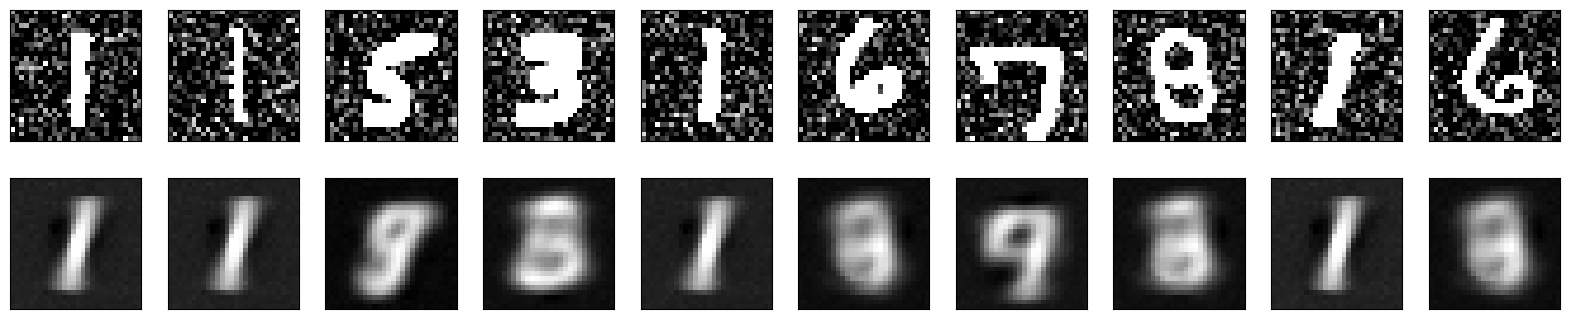

In [11]:
display_diff(x_test_noisy, y_hat['recon'])